### Team Member 1:
* UNI: mf3090
* Name: Michael Figueroa

### Team Member 2:
* UNI: baa2146
* Name: Brett Averso

## Team: Two dudes from Queens

## Task

A banking institution ran a direct marketing campaign based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed or not. This project predicts whether someone will subscribe to the term deposit or not based on the given information.

## Method

This script was performed with Amazon EC2 enviornment using m4.16xlarge processing instance. Please note 64 CPU processors was employed in parallel, although this amount of processors is entirely unnecessary. We benefit from parallel computing for running wide grid searches for parameter tunings and as much as 25 cross validations. With the savings in computing time, we iterated through 5 pre-processed versions of our data as well.

All of our models included standard scalar on the continous variables only and we dealt with the unknown categorical variables by creating dummy features for each. We manually dropped the previous_days columns which contained over 80% of missing data. These preprocessing were applied to every model. When we used algorithmic feature selection (Select From Model), we employed 5 different estimators using the median threshold. This was advantageous because we had five various train/test sets that we applied to our models and ensembles in order to further tune our performance. Additionally, we reviewed the features in a table and applied our own rational judgement as to which features are relevant.

We analyzed 8 poor man's stacking ensembles, a hold-out stacking ensemble, and employed undersampling imblearn ensemble. Our final model combines our strongest estimators (Random Forest, LDA, MLP Neural Net). To avoid overfitting we chose parameters which reduce the number of trees in RF, and limited our Neural Network to just 1 layers of several nodes. We later found out that by employing a second Neural Net on a random state different from the original, we earned a higher ROC-AUC. While we this ensemble employs two of the same estimator, we're confident that the second NN is providing reduced variance at no cost to bias. On this ensemble we included data with features selected using LassoCV in SelectFromModel(). This is because none of the models in the ensemble employ an L1 penalty and we onbserved this feature selection method to be best for generalization of the data.

Our second chosen ensemble includes a similar variation: (Random Forest, Gradient Booosted Trees, Logistic Regression, MLP Neural Net). As before, the Neural Net was a single layer of several hidden nodes. We were simply to include more estimators to ensure that we successfully average out any error. Note that in this model, the logistic regression employs an L1 penalty so we did not wish to double down on the penalization and used the full train/test set (no algorithmic feature selection employed). We also weighted the simplyer models greater than the Neural Nets this time as we felt too much voting power was being given to these two estimators.

We also emplyoed an imblearn random undersampling ensemble on our favored group of estimators. This did not perform as well, as our cross validation score was low as well as the hold-out. We used the ROC AUC as a metric across the baord as a metric for model evaluation.

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [1]:
cd data

/Users/brettaverso/Desktop/HW3 AML/homework-iii-baverso-master/data


In [27]:
#test the parallel processing EC2 instance (commented out)
'''import os
from IPython import parallel
c = parallel.Client()
view = c.load_balanced_view()

from sklearn.externals.joblib import cpu_count
print(cpu_count())

import pickle
%px print('hi')'''

"import os\nfrom IPython import parallel\nc = parallel.Client()\nview = c.load_balanced_view()\n\nfrom sklearn.externals.joblib import cpu_count\nprint(cpu_count())\n\nimport pickle\n%px print('hi')"

In [2]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.gaussian_process import GaussianProcessClassifier, kernels
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import f_classif
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler

# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

In [3]:
#import data, impute any 'not applicable/unknown' codes to NaN: 
train = pd.read_csv('data.csv', sep=',', na_values=[999, 9999, 99999, 999999, 9999999])
test = pd.read_csv('holdout.csv', sep=',')

In [5]:
#exploring the data.
def explore():
    for i in list(test):
        print(test[i].value_counts())

    #verifying the existence of any null values other than 'unknown'
    print(train.isnull().any())

In [6]:
explore()

2047    1
1274    1
5440    1
7489    1
1346    1
3395    1
5448    1
7497    1
1354    1
3403    1
5456    1
7505    1
1362    1
3411    1
5464    1
7513    1
1370    1
3419    1
5472    1
7521    1
1378    1
3427    1
5480    1
7529    1
1386    1
3435    1
5488    1
7537    1
1394    1
3443    1
       ..
4759    1
6782    1
4735    1
2692    1
645     1
6790    1
4743    1
2700    1
653     1
6798    1
4751    1
2708    1
661     1
6806    1
2716    1
6838    1
669     1
6814    1
4767    1
2724    1
677     1
6822    1
4775    1
2732    1
685     1
6830    1
4783    1
2740    1
693     1
2049    1
Name: ID, dtype: int64
35.0    360
34.0    345
31.0    324
37.0    322
33.0    306
32.0    302
30.0    302
38.0    295
36.0    291
40.0    279
39.0    264
29.0    253
43.0    242
42.0    222
41.0    222
45.0    217
44.0    217
47.0    213
28.0    205
48.0    198
49.0    192
46.0    189
50.0    178
51.0    171
27.0    168
26.0    167
52.0    159
55.0    138
53.0    135
54.0    133
       

In [4]:
# we have an imbalanced dataset (~ 10 times more yes classes)
print(" -----%-------")
print(train['subscribed'].value_counts())

 -----%-------
no     29238
yes     3712
Name: subscribed, dtype: int64


In [5]:
#reciewing the statistics of the features in the data
train.describe()

,age,duration,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,32950.000000,32948.000000,32950.000000,1243.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.019059,257.723504,2.641639,5.938053,0.174385,0.080115,93.583705,-40.496740,3.618901,5166.932832
std,10.850807,258.813007,2.803230,3.765920,0.498989,1.573180,1.162662,4.645301,1.737149,72.439480
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.695294,88.311974,-52.220779,0.325461,4963.600000
25%,32.000000,102.000000,1.000000,3.000000,0.000000,-1.724208,92.800661,-43.087110,1.377065,5101.000000
50%,38.000000,180.000000,2.000000,6.000000,0.000000,1.085053,93.586959,-41.685507,4.800570,5194.000000
75%,47.000000,318.000000,3.000000,7.000000,0.000000,1.366367,94.381404,-36.404580,4.943674,5226.000000
max,97.000000,4924.000000,56.000000,27.000000,7.000000,1.785673,98.263042,-25.323735,5.362403,5249.000000


In [4]:
def preprocess(train, test):
    #dropping features: test id, duration, prev_days, subscriptions
    #drop duration column (we do not have this information before a new call. we drop to avoid an overly optimistic model)
    #dropping prev_days because the feature contains 31707 null values (80% missing). Not likely an informative feature.
    test_ID = test.ID
    y_train = train.subscribed
    test = test.drop(['ID','duration','prev_days'], axis = 1)
    train = train.drop(['duration','prev_days','subscribed'], axis = 1)
    
    #assign binary for no and yes
    y_train.replace('no',0, inplace=True)
    y_train.replace('yes',1, inplace=True)
    
    #creating dummy variables for categorical features
    dummy_train = pd.get_dummies(train,dummy_na=False)
    dummy_test = pd.get_dummies(test,dummy_na=False)
    
    #noted test set is missing a feature, imputing a 0 vector for this feature at the appropriate column index.
    list(dummy_test)[33]
    dummy_test.insert(34, 'credit_default_yes', 0)
    
    return dummy_train, dummy_test, y_train, test_ID

In [5]:
dummy_train, dummy_test, y_train, test_ID = preprocess(train, test)

In [9]:
# correlation between features and response variable
def mutual_info(dummy_train, y_train):
    mi = mutual_info_classif(dummy_train.values, y_train.values)
    inds = np.argsort(mi)

    plt.figure(figsize=(5, 30))
    plt.barh(np.arange(len(mi)), np.log(mi[inds] + 1))
    plt.yticks(np.arange(len(mi)), dummy_train.columns[inds])
    plt.ylim(0, len(mi))
    # Based upon the below, the first six features have strong correlations.

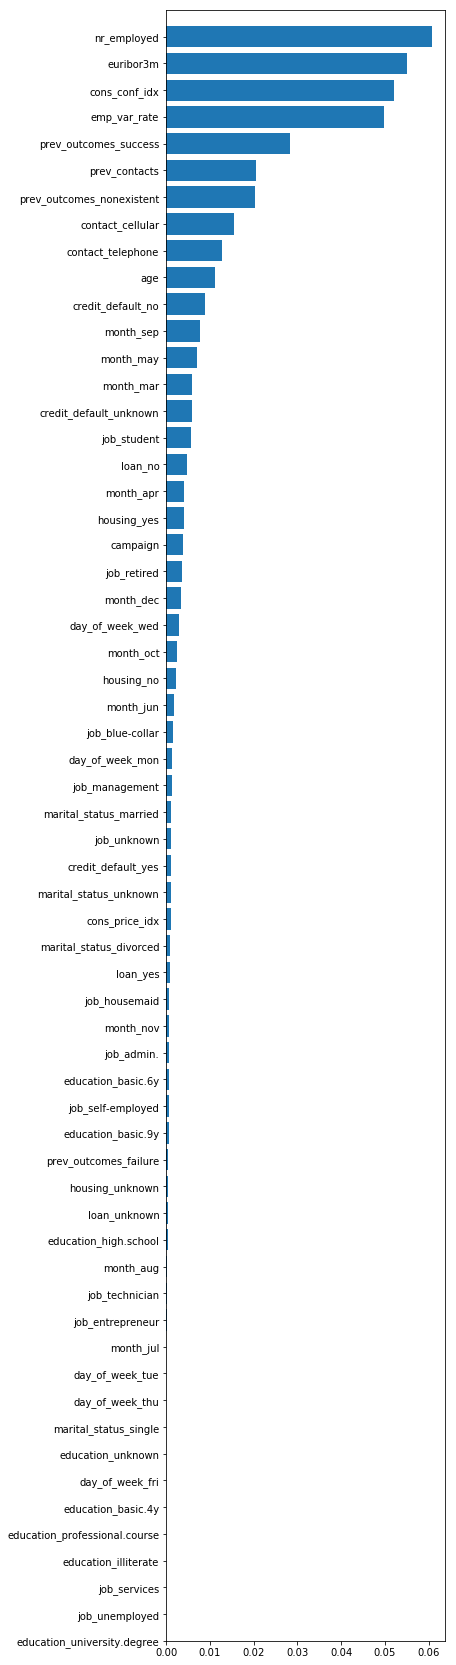

In [15]:
'''mutual_info(dummy_train, y_train)
This cell is commented so Travis will run faster.'''

In [11]:
def scatter_plot():
    #viewing the scatter matrix on discrete features. The scatters suggest tree based modeling may be better due to a lack
    #of linear seperability. 
    scatter_data = pd.concat((train[['age','campaign','emp_var_rate','cons_price_idx','euribor3m','nr_employed']],y_train),axis=1)
    ax = pd.scatter_matrix(scatter_data, c= y_train, alpha=0.6, figsize=(15, 15), diagonal='hist')

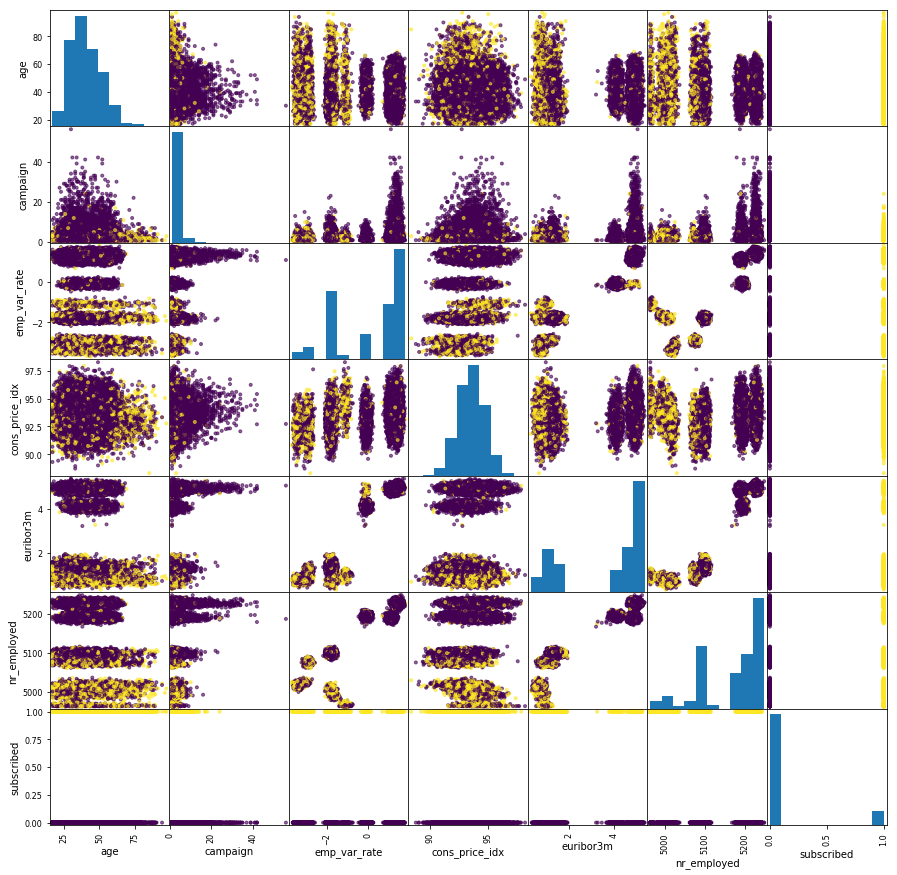

In [12]:
'''scatter_plot()
This execution cell is commented so Travis will run faster'''

In [13]:
#reviewing the mean of various features according to subscription.
def groupby_mean():
    for i in list(train.select_dtypes(exclude=['float'])):
        plt.figure()
        y_train.groupby(train[i]).mean().sort_values().plot(kind="barh")

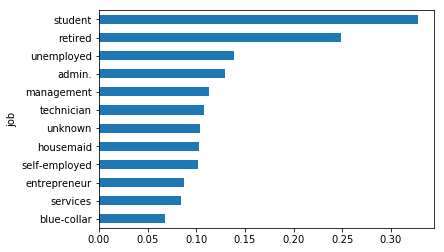

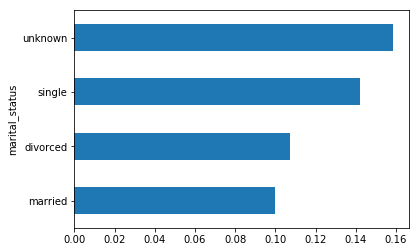

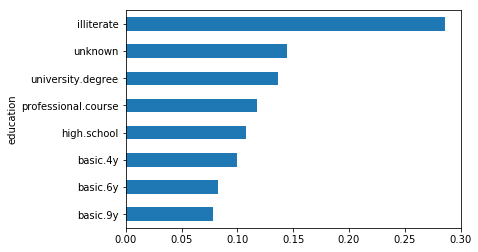

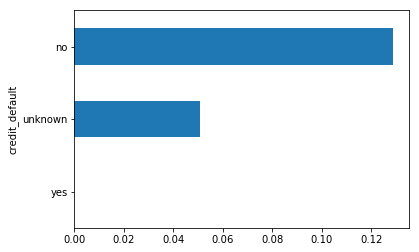

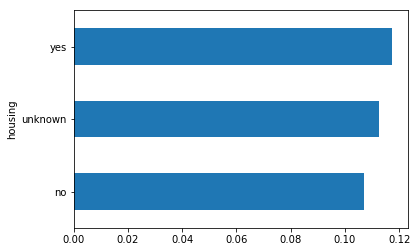

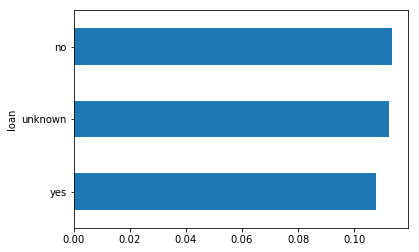

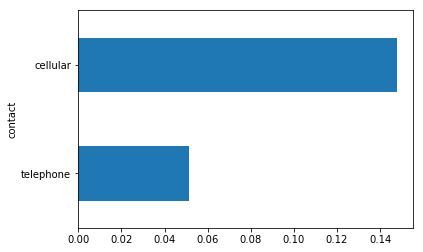

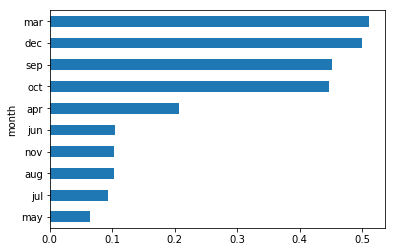

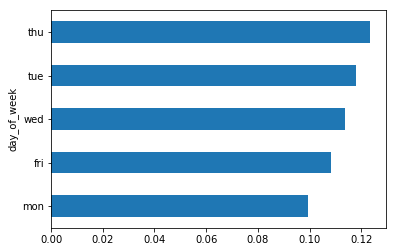

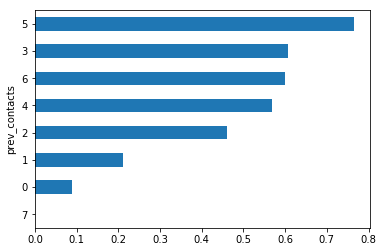

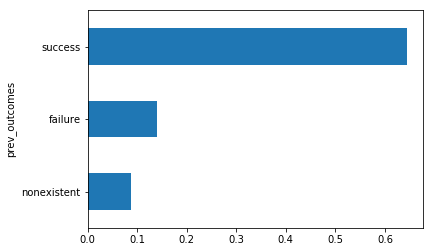

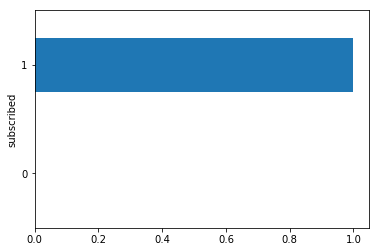

In [14]:
'''groupby_mean()
This cell commented so Travis will run faster.'''

In [15]:
#reviewing the listing of categorical data prior to executing get_dummies
categoricals = list(train.select_dtypes(include=['object']))
categoricals

['job',
 'marital_status',
 'education',
 'credit_default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'prev_outcomes']

In [6]:
# We chose to scale outside of our pipelines, because we only wanted to scale continuous variables.

def scale_continuous(dummy_train, dummy_test):

    # scaling the continuous data
    continuous_train = dummy_train.select_dtypes(include=['float'])
    categorical_train = dummy_train.select_dtypes(exclude=['float'])

    continuous_test = dummy_test.select_dtypes(include=['float'])
    categorical_test = dummy_test.select_dtypes(exclude=['float'])

    # note scalar fits to train only! This prevents leakage. It transforms on train and test.
    scaler = StandardScaler()
    dummy_train_scaled = scaler.fit_transform(continuous_train)
    dummy_test_scaled = scaler.transform(continuous_test)
    dummy_train_scaled = pd.DataFrame(dummy_train_scaled,columns=list(continuous_train))
    dummy_test_scaled = pd.DataFrame(dummy_test_scaled,columns=list(continuous_test))

    # Combining continuous and dummy features back into a single train data frame.
    X_train = pd.concat([dummy_train_scaled, categorical_train],axis=1)
    X_test = pd.concat([dummy_test_scaled,categorical_test],axis=1)
    
    return X_train, X_test

In [7]:
X_train, X_test = scale_continuous(dummy_train, dummy_test)

In [18]:
#Covariance matrix heat map is another way to examine correlations between features.
#The map indicates the economic indicators are strongly correlated, but that's about it.

def covariance_heat():
    cov = (np.cov(X_train, rowvar=False))
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(cov, cmap=plt.cm.Blues)
    fig = plt.gcf()
    fig.set_size_inches(25, 25)
    plt.xticks(np.arange(61),tuple(list(X_train)))
    plt.yticks(np.arange(61),tuple(list(X_train)))

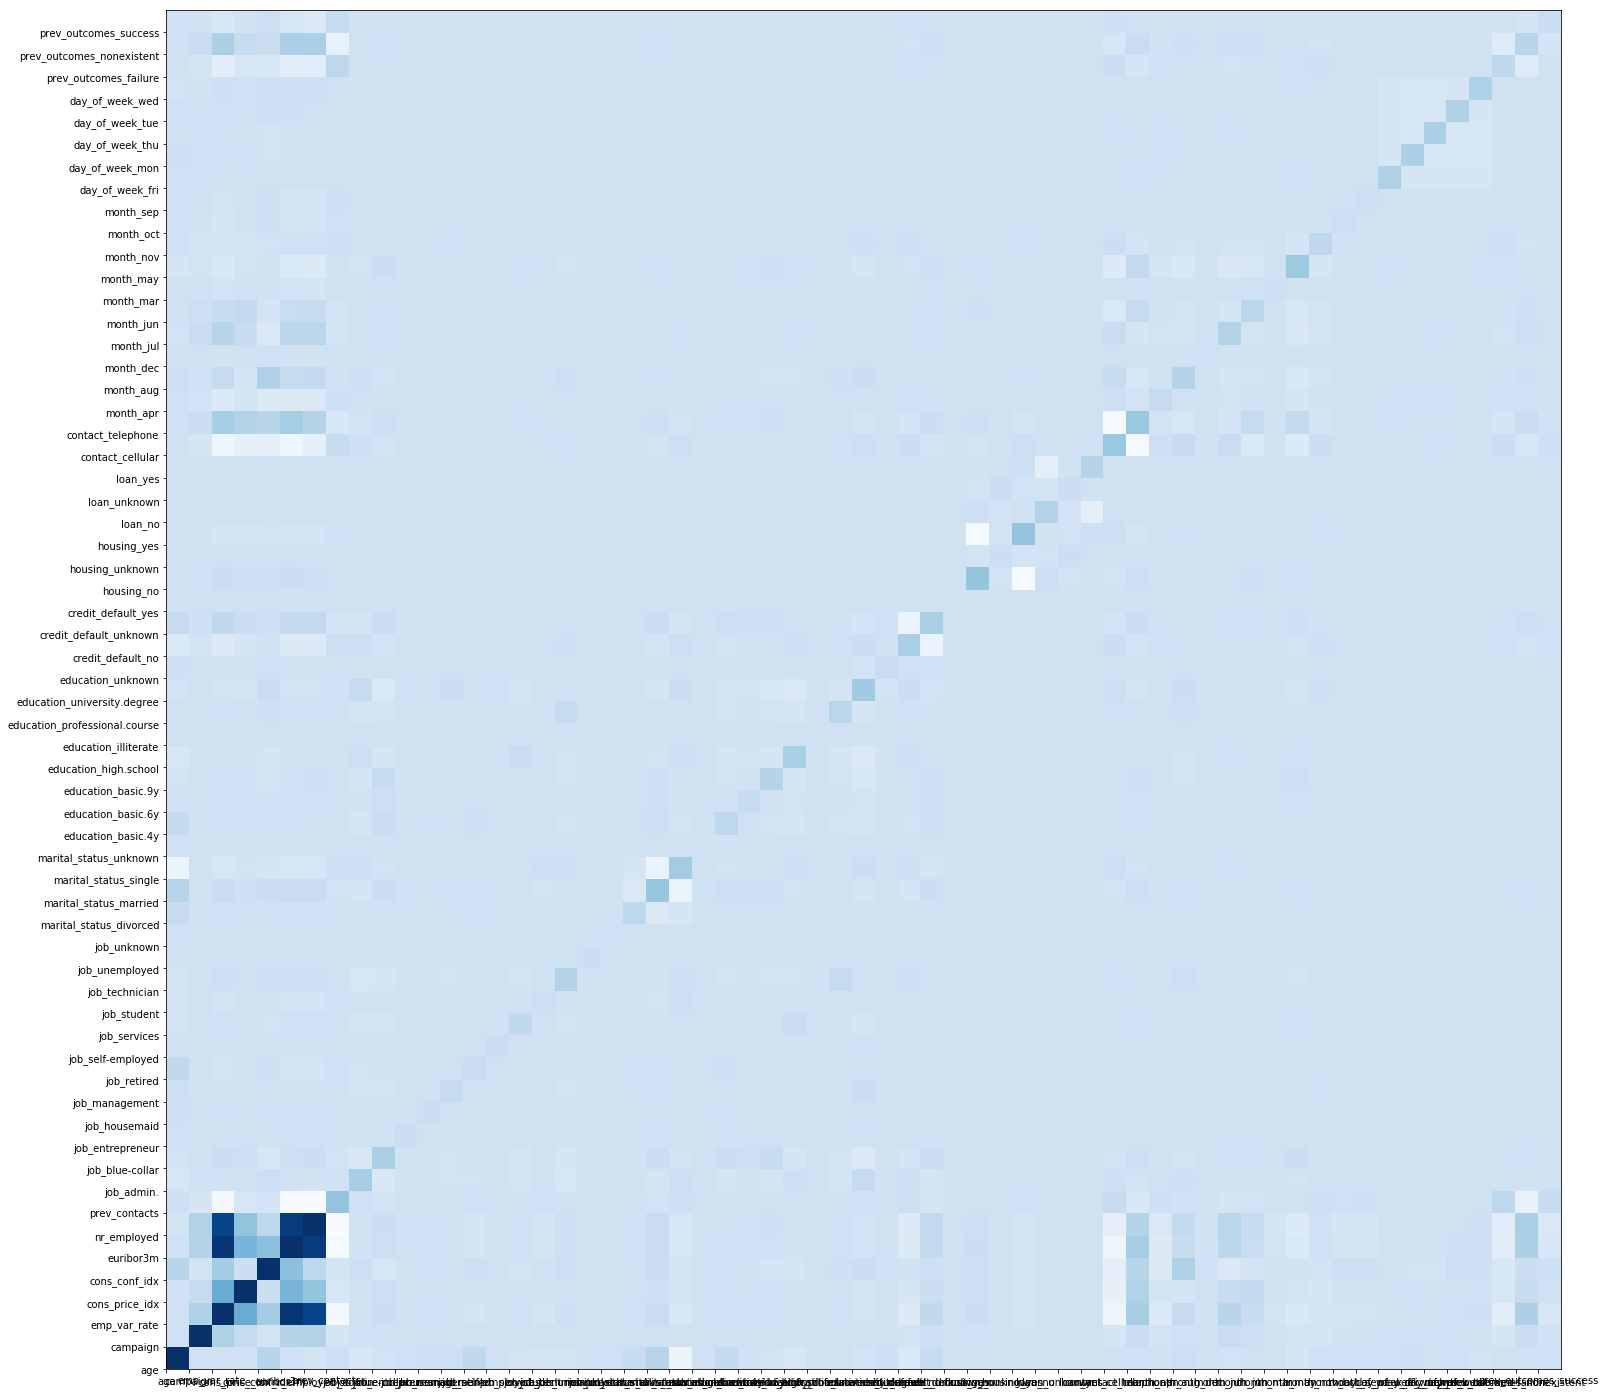

In [19]:
covariance_heat()

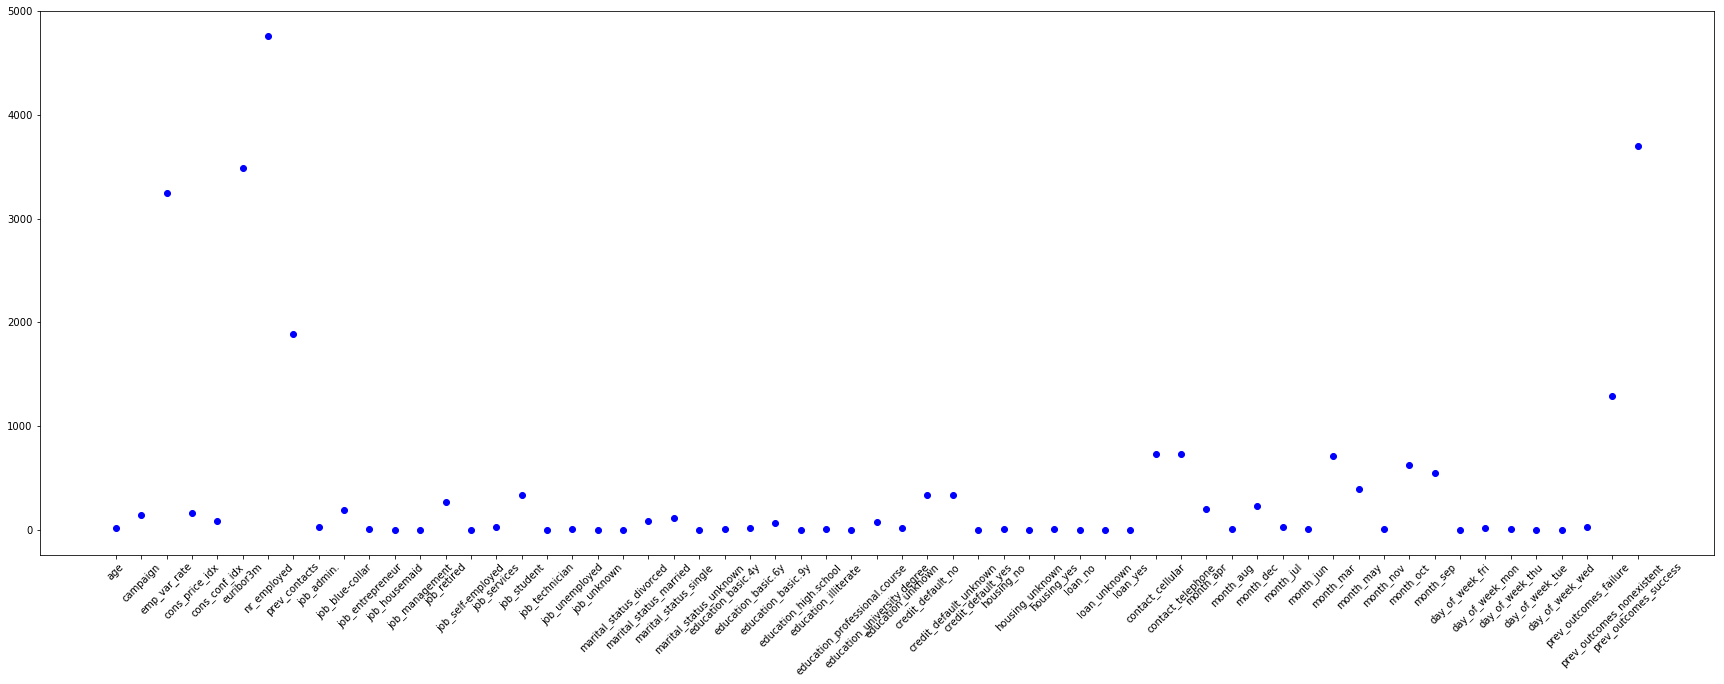

In [20]:
#examine f-value and p-values of our features
f_values, p_values = f_classif(X_train, y_train)

#f-values:
plt.figure(figsize=(30,10))

plt.plot(f_values, 'bo')
plt.xticks(np.arange(61),tuple(list(X_train)), rotation = 45)
plt.show()

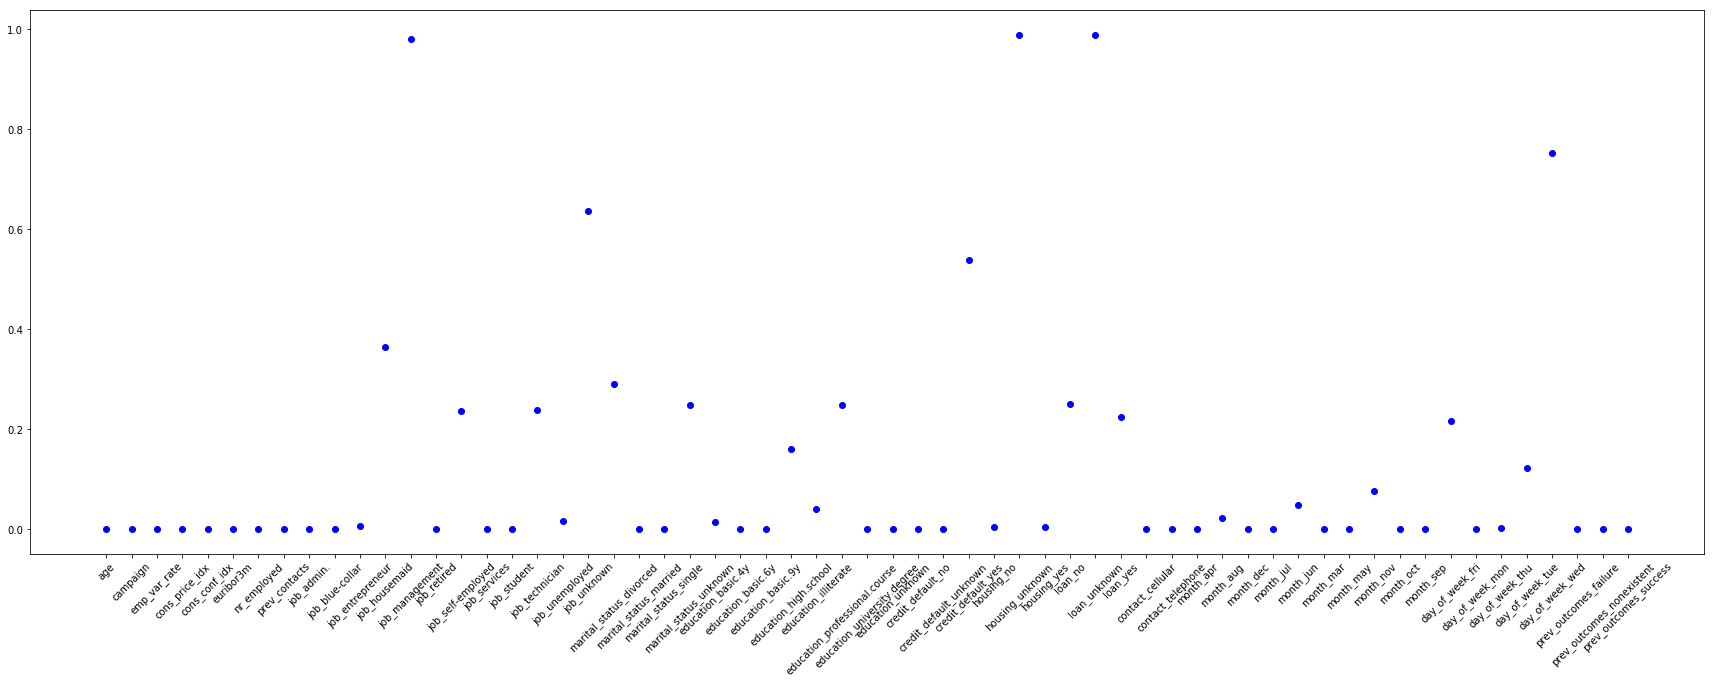

In [21]:
#p-values:
plt.figure(figsize=(30,10))

plt.plot(p_values, 'bo')
plt.xticks(np.arange(61),tuple(list(X_train)), rotation = 45)
plt.show()

In [8]:
def model_search_feature_selection(X_train, y_train):
    '''This is our model search feature selection function. We examined 5 estimation methods for algorithmic 
    feature selection: LassoCV, LinearSVC with L1 penalty, LinearSVC with L2 penalty, ExtraTrees, and Random Forest.
    The top half of all features were selected.
    
    Returns: comparison (a dataframe of the features chosen by each respective feature selection method),
    and all preprocessed train / test matrices.'''
    sfm1 = SelectFromModel(LassoCV(), threshold="median")
    X_train_1 = sfm1.fit_transform(X_train, y_train)
    X_test_1 = sfm1.transform(X_test)
    indices = sfm1.get_support(indices=False)  
    test1 = pd.DataFrame(indices,columns=['LassoCV'])
    
    sfm2 = SelectFromModel(LinearSVC(), threshold="median")
    X_train_2 = sfm2.fit_transform(X_train, y_train)
    X_test_2 = sfm2.transform(X_test)
    indices = sfm2.get_support(indices=False)
    test2 = pd.DataFrame(indices,columns=['LinearSVC-l2'])
    
    sfm3 = SelectFromModel(LinearSVC(penalty='l1', dual=False), threshold="median")
    X_train_3 = sfm3.fit_transform(X_train, y_train)
    X_test_3 = sfm3.transform(X_test)
    indices = sfm3.get_support(indices=False)
    test3 = pd.DataFrame(indices,columns=['LinearSVC-l1'])
    

    sfm4 = SelectFromModel(ExtraTreesClassifier(), threshold="median")
    X_train_4 = sfm4.fit_transform(X_train, y_train)
    X_test_4 = sfm4.transform(X_test)
    indices = sfm4.get_support(indices=False)
    test4 = pd.DataFrame(indices,columns=['ExtraTrees'])
    
    sfm5 = SelectFromModel(RandomForestClassifier(random_state=0), threshold="median")
    X_train_5 = sfm5.fit_transform(X_train, y_train)
    X_test_5 = sfm5.transform(X_test)
    indices = sfm5.get_support(indices=False)
    test5 = pd.DataFrame(indices,columns=['RandomForest'])
    
    
    comparison = pd.concat((pd.DataFrame(list(X_train),columns=['feature']),test1,test2,test3,test4,test5),axis=1)
    
    return comparison, X_train_1, X_train_2, X_train_3, X_train_4, X_train_5, X_test_1, X_test_2, X_test_3, X_test_4, X_test_5

In [9]:
comparison, X_train_1, X_train_2, X_train_3, X_train_4, X_train_5, X_test_1, X_test_2, X_test_3, X_test_4, X_test_5 = model_search_feature_selection(X_train, y_train)

In [24]:
comparison

,feature,LassoCV,LinearSVC-l2,LinearSVC-l1,ExtraTrees,RandomForest
0,age,False,False,False,True,True
1,campaign,True,False,False,True,True
2,emp_var_rate,True,True,True,True,True
3,cons_price_idx,False,False,False,True,True
4,cons_conf_idx,True,False,True,True,True
5,euribor3m,True,True,True,True,True
6,nr_employed,True,True,True,True,True
7,prev_contacts,True,False,True,True,True
8,job_admin.,True,False,False,True,True
9,job_blue-collar,True,False,False,True,True


# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

In [10]:
def kaggle_output(y_prob):
    #this program outputs our predicted probabilities to file for Kaggle.
    y_prob = y_prob.ix[:,[1]]
    y_prob = pd.concat([test_ID, y_prob], axis = 1)
    y_prob.columns = ['ID', 'subscribed']
    y_prob.to_csv('output.csv', index=False)

In [11]:
def model_1(X_train, y_train, X_test):
    logit = LogisticRegression(penalty = 'l1',random_state=0)
    #L1 is used because it brings some features' norms to zero, thereby selecting features by importance.
    pipe = make_pipeline(logit)
    param_grid = {'logisticregression__C': [.01, .1, 1.0]}
    grid = GridSearchCV(pipe, param_grid, cv = 5, scoring = 'roc_auc', n_jobs=-1, verbose=5)
    #note to TA: you may wish to turn off verbose if it slows down runtime for you.
    grid.fit(X_train, y_train)
    score_mean = grid.best_score_
    grid_data = grid.best_estimator_.named_steps['logisticregression']
    y_prob = grid.best_estimator_.named_steps['logisticregression'].predict_proba(X_test)
    y_prob = pd.DataFrame(y_prob)
    return y_prob, score_mean, grid_data
#L1 penalty, c = 0.1, roc_auc is .79090366
#L1 penalty, c = 0.1, feature_selection_method_1, roc_auc is .79284
#L1 penalty, c = 1.0, feature_selection_method_2, roc_auc is .79196
#L1 penalty, c = 1.0, feature_selection_method_3, roc_auc is .79207
#L1 penalty, c = 0.1, feature_selection_method_4, roc_auc is .78799
#L1 penalty, c = 1.0, feature_selection_method_5, roc_auc is .781674
#L1 penalty, c = 1.0, feature_selection_method_1, roc_auc is .792836

In [30]:
'''This cell represents an example of how to execute the code for one particular model.
It is commented here so Travis will run faster. Note px is a command for parallel computing.
#%px

y_prob, score_mean, grid_data = model_1(X_train_1, y_train, X_test_1)'''

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] logisticregression__C=0.01 ......................................
[CV] logisticregression__C=0.01 ......................................
[CV] logisticregression__C=0.01 ......................................
[CV] logisticregression__C=0.01 ......................................
[CV] logisticregression__C=0.01 ......................................
[CV] logisticregression__C=0.1 .......................................
[CV] logisticregression__C=0.1 .......................................
[CV] logisticregression__C=0.1 .......................................
[CV] logisticregression__C=0.1 .......................................
[CV] logisticregression__C=0.1 .......................................
[CV] logisticregression__C=1.0 .......................................
[CV] ....... logisticregression__C=0.01, score=0.789608, total=   0.2s
[CV] logisticregression__C=1.0 .......................................
[CV] logisticregr

[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.4s remaining:    1.2s


[CV] ........ logisticregression__C=0.1, score=0.799883, total=   0.5s
[CV] ........ logisticregression__C=0.1, score=0.793685, total=   0.6s
[CV] ........ logisticregression__C=0.1, score=0.784020, total=   0.5s
[CV] ........ logisticregression__C=0.1, score=0.795128, total=   0.6s
[CV] ........ logisticregression__C=0.1, score=0.785434, total=   0.7s


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.8s remaining:    0.7s


[CV] ........ logisticregression__C=1.0, score=0.796006, total=   0.9s
[CV] ........ logisticregression__C=1.0, score=0.795085, total=   1.0s
[CV] ........ logisticregression__C=1.0, score=0.785221, total=   0.9s
[CV] ........ logisticregression__C=1.0, score=0.787039, total=   1.0s
[CV] ........ logisticregression__C=1.0, score=0.800831, total=   1.0s


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.4s finished


In [82]:
'''This GP Classifier model is called garbage because it fails to converge.
Please note we attempted kernel approximation but it still failed.

def garbage(X_train, y_train, X_test):    
    approxRBF = RBFSampler(random_state=0)
    GP = GaussianProcessClassifier(random_state=0)
    pipe = make_pipeline(approxRBF, GP)
    pipe.fit(X_train, y_train)
    score = pipe.score(X_train, y_train, scoring= 'roc_auc')
    scores = cross_val_score(pipe, X_train_rbf, y_train, cv=5, scoring = 'roc_auc', verbose=5, n_jobs=-1)
    score_mean = np.mean(scores)
    y_prob = pipe.predict_proba(X_test)
    y_prob = pd.DataFrame(y_prob)
    return y_prob, score, score_mean
'''

In [12]:
def model_2(X_train, y_train, X_test):
    lsvc = LinearSVC(C=10, dual = False, random_state=0)
    clf = CalibratedClassifierCV(lsvc)
    pipe = make_pipeline(clf)  
    pipe.fit(X_train, y_train)
    scores = cross_val_score(pipe, X_train, y_train, cv=20, scoring = 'roc_auc', n_jobs=-1,verbose=True)
    y_prob = pipe.predict_proba(X_test)
    y_prob = pd.DataFrame(y_prob)
    return y_prob, scores
#C=1, cross_val=20, dual = False, score = ..788617
#C=.5, cross_val=20, dual = False, score = .788619
#C=5, cross_val=20, dual = False, score = .788627
#C=5, cross_val=20, dual = True, score = .7887216
#C=10, cross_val=20, dual = False, score = .788622

In [13]:
def model_3(X_train, y_train, X_test):    
    NB = GaussianNB()
    pipe = make_pipeline(NB)
    pipe.fit(X_train, y_train)
    scores = cross_val_score(pipe, X_train, y_train, cv=10, scoring = 'roc_auc', n_jobs=-1)
    y_prob = pipe.predict_proba(X_test)
    y_prob = pd.DataFrame(y_prob)
    return y_prob, scores
# on X_train , cv = 10 , roc_auc: 0.68667678300455237
# on X_train_1 , cv = 10 , roc_auc: 0.86673748103186643
# on X_train_2 , cv = 10 , roc_auc: 0.82418816388467375
# on X_train_3 , cv = 10 , roc_auc: 0.84145675265553865
# on X_train_4 , cv = 10 , roc_auc: 0.83951441578148711
# on X_train_5 , cv = 10 , roc_auc: 0.81890743550834599

In [14]:
def model_4(X_train, y_train, X_test):    
    LDA = LinearDiscriminantAnalysis(solver = 'svd')
    pipe = make_pipeline(LDA)
    pipe.fit(X_train, y_train)
    scores = cross_val_score(pipe, X_train, y_train, cv=20, scoring = 'roc_auc', n_jobs=-1)
    y_prob = pipe.predict_proba(X_test)
    y_prob = pd.DataFrame(y_prob)
    return y_prob, scores
# solver svd: mean of cv = 10  using X_train , roc_auc: 0.78839474
# solver svd: mean of cv = 10  using X_train_1, roc_auc: 0.79032690991282672
# solver svd: mean of cv = 10  using X_train_2, roc_auc: 0.78970247763440915
# solver svd: mean of cv = 10  using X_train_3, roc_auc: 0.78983851265468485
# solver svd: mean of cv = 10  using X_train_4, roc_auc: 0.78280622904062491
# solver svd: mean of cv = 10  using X_train_5, roc_auc: 0.78298792357946079

# solver svd: mean of cv = 20  using X_train, roc_auc: 0.7887373965352904
# solver svd: mean of cv = 20  using X_train_1, roc_auc: 0.79042111401968673
# solver svd: mean of cv = 20  using X_train_2, roc_auc: 0.78858452751321428
# solver svd: mean of cv = 20  using X_train_3, roc_auc: 0.78489727804588838
# solver svd: mean of cv = 20  using X_train_4, roc_auc: 0.78005401117436901
# solver svd: mean of cv = 20  using X_train_5, roc_auc: 0.77369847196384811


# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In [15]:
def model_5(X_train, y_train, X_test):
    gbt = GradientBoostingClassifier(n_estimators = 120, random_state = 0)
    pipe = make_pipeline(gbt)
    param_grid = {'gradientboostingclassifier__learning_rate': [.1, .13, .15, .2, .25],
                 'gradientboostingclassifier__max_depth': [1,2,3,4,5]}
    grid = GridSearchCV(pipe, param_grid, cv = 15, scoring = 'roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    score_mean =  grid.best_score_
    grid_data = grid.best_estimator_.named_steps['gradientboostingclassifier']
    y_prob = grid.best_estimator_.named_steps['gradientboostingclassifier'].predict_proba(X_test)
    y_prob = pd.DataFrame(y_prob)
    return y_prob, score_mean, grid_data

#X_test, recommended learning rate = 0.1, recommend max_depth = 4 , roc_auc = .7979222
#X_test_1, recommended learning rate = 0.1 , recommend max_depth = 4 , roc_auc = .796868878
#X_test_2, recommended learning rate = 0.13, recommend max_depth = 2 , roc_auc = .795696015
#X_test_3, recommended learning rate = 0.1 , recommend max_depth = 3, roc_auc = .79398085
#X_test_4, recommended learning rate = 0.1, recommend max_depth = 3 , roc_auc = .79319342
#X_test_5, recommended learning rate = 0.1, recommend max_depth = 2 , roc_auc = .78235297

In [16]:
def model_6(X_train, y_train, X_test):
    rf = RandomForestClassifier(max_depth = 5, n_estimators=100, random_state = 0)
    pipe = make_pipeline(rf)
    param_grid = {'randomforestclassifier__max_features': [6, 8, 10, 15]}
    grid = GridSearchCV(pipe, param_grid, cv = 20, scoring = 'roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    score_mean = grid.best_score_
    grid_data = grid.best_estimator_.named_steps['randomforestclassifier']
    y_prob = grid.best_estimator_.named_steps['randomforestclassifier'].predict_proba(X_test)
    y_prob = pd.DataFrame(y_prob)
    return y_prob, score_mean, grid_data
# max_depth = 5, n_estimators = 110, max_features=6, roc_auc=.8008
# max_depth = 5, n_estimators = 50, max_features=6, roc_auc=.8002
# max_depth = 5, n_estimators = 20, max_features=6, roc_auc=.7977
# max_depth = 20, n_estimators = 110, max_features=6, roc_auc=.9957 (submitted)
# max_depth = 10, n_estimators = 110, max_features=10, roc_auc=.8694202
# max_depth = 10, n_estimators = 50, max_features=10, roc_auc=.856371
# max_depth = 10, n_estimators = 20, max_features=10, roc_auc=.850750 (submitted)
# max_depth = None, n_estimators = 100, max_features=8, roc_auc = .779714283
# max_depth = 5, n_estimators = 100, max_features = 10, roc_auc = .7948667021

In [17]:
def model_7(X_train, y_train):
    mlp = MLPClassifier(solver='lbfgs',random_state=0)
    mlp_pipe =  make_pipeline(mlp)
    param_grid = {'mlpclassifier__alpha': [.001, .004, .006, .008],
                 'mlpclassifier__hidden_layer_sizes': [(5,)]}
    grid = GridSearchCV(mlp_pipe, param_grid, cv=5, scoring = "roc_auc")
    grid.fit(X_train, y_train)
    score_mean = grid.best_score_
    grid_data = grid.best_estimator_.named_steps['mlpclassifier']
    y_prob = grid.best_estimator_.named_steps['mlpclassifier'].predict_proba(X_test)
    y_prob = pd.DataFrame(y_prob)
    return y_prob, score, grid_data
#with alpha .001 and hidden layer of 5, neurons=100 the score is .80335
#with alpha .01 and hidden layer of 5, neurons=100 the score is .804585
#with alpha .1 and hidden layerof 5, neurons=100 the score is .8010487
#with alpha .006 and hidden layer of 4, neurons=100 the score is .8029616
#with alpha .006 and hidden layer of 1, neurons=100 the score is .7779076
#with alpha .006 and hidden layer of 1, neurons=5, solver=lbfgs, the score is .81554038
#with alpha .007 and hidden layer of 1, neurons=4, solver=lbfgs, teh score is .8043711
#with alpha .01 and hidden layer of 1, neurons=4, solver=lbfgs, the score is .804385
#with alpha .004 and hidden layer of 1, neurons=4, solver=lbfgs, the score is .80422
#with alpha .004 and hidden layer of 1, neurons=5, solve=lbfgs, teh score is .8161554

# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [11]:
def poorman1(X_train, y_train, X_test):
    
    RF = RandomForestClassifier(max_depth = 5, n_estimators = 100, max_features=10, random_state=0)
    LDA = LinearDiscriminantAnalysis(solver = 'svd')
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)
    
    voting = VotingClassifier(estimators=[('lda', LDA), ('rf', RF), ('gnb', MLP)], voting='soft', weights=[1,3,2])
    voting.fit(X_train, y_train)
    scores = cross_val_score(voting, X_train, y_train, cv=5, scoring = 'roc_auc')
    predictions = (voting.predict_proba(X_test))
    predictions = pd.DataFrame(predictions)
    
    return scores, predictions


# We used the models which performed best on the holdout set individually to build this poorman stack.
# The parameters reflect choices which we believe will generalize well to the holdout data on kaggle.
# In this particular model we weighted teh variabels. Mean score ROC_AUC: .797602

In [ ]:
def poorman2(X_train, y_train, X_test):
    
    LOG = LogisticRegression(C= .1, penalty= 'l1', random_state=0)
    LDA = LinearDiscriminantAnalysis(solver = 'svd')
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)

    voting = VotingClassifier(estimators=[('log', LOG), ('LDA', LDA), ('mlp', MLP)], voting='soft')
    voting.fit(X_train, y_train)
    scores = cross_val_score(voting, X_train, y_train, cv=5, scoring = 'roc_auc')
    predictions = (voting.predict_proba(X_test))
    predictions = pd.DataFrame(predictions)

    return scores , predictions

# Using Select from model 1: LDA, RF: maxdepth = 5, n_estimators = 50, max_features = 6, 
# MLPClassifier: alpha = .004, hiddenlayer = (5,1)
# roc_auc cv = 5: .78324564

In [ ]:
def poorman3(X_train, y_train, X_test):
    
    RF = RandomForestClassifier(max_depth = 5, n_estimators= 110, max_features=6)
    GB = GradientBoostingClassifier(learning_rate = .1, max_depth=4)
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)
    LDA = LDA = LinearDiscriminantAnalysis(solver = 'svd')
    
    reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_,1).reshape(-1,8)[:,1::2], validate=False)
    voting = VotingClassifier(estimators=[('rf', RF), ('gb', GB), ('mlp', MLP), ('lda', LDA)], voting='soft')
    pipe = make_pipeline(voting, reshaper, LogisticRegression(C=100))
    pipe.fit(X_train, y_train)
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring = 'roc_auc')
    predictions = (pipe.predict_proba(X_test))
    predictions = pd.DataFrame(predictions)
    
    return scores, predictions

# Using Select from model 1: cv = 5 ,roc_auc: 0.77352794430764293

In [19]:
def poorman4(X_train, y_train, X_test):
    
    RF = RandomForestClassifier(max_depth = 5, n_estimators = 100, max_features=10, random_state=0)
    LDA = LinearDiscriminantAnalysis(solver = 'svd')
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)
    MLP2 = MLPClassifier(alpha = .004, hidden_layer_sizes = (10,), solver = 'lbfgs', random_state = 1)
    
    voting = VotingClassifier(estimators=[('lda', LDA), ('rf', RF), ('gnb', MLP), ('gnb2', MLP2)], voting='soft', weights=[1,2,3,3])
    voting.fit(X_train, y_train)
    scores = cross_val_score(voting, X_train, y_train, cv=5, scoring = 'roc_auc')
    predictions = (voting.predict_proba(X_test))
    predictions = pd.DataFrame(predictions)
    
    return scores, predictions


# We used the models which performed best on the holdout set individually to build this poorman stack.
# The parameters reflect choices which we believe will generalize well to the holdout data on kaggle.
# In this particular model we weighted teh variabels. Mean score ROC_AUC: .8013246

In [26]:
def poorman5(X_train, y_train, X_test):
    
    RF = RandomForestClassifier(max_depth = 5, n_estimators = 100, max_features=10, random_state=0)
    LREG = LogisticRegression(C=0.1,)
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)
    MLP2 = MLPClassifier(alpha = .004, hidden_layer_sizes = (10,), solver = 'lbfgs', random_state = 0)
    
    voting = VotingClassifier(estimators=[('rf', RF), ('lrg', LREG), ('gnb', MLP), ('gnb2', MLP2)], voting='soft', weights=[1,2,3,3])
    voting.fit(X_train, y_train)
    scores = cross_val_score(voting, X_train, y_train, cv=5, scoring = 'roc_auc')
    predictions = (voting.predict_proba(X_test))
    predictions = pd.DataFrame(predictions)
    
    return scores, predictions
#ROC AUC .793298657

In [32]:
def poorman6(X_train, y_train, X_test):
    
    GB = GradientBoostingClassifier(learning_rate = .1, max_depth=4)
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)
    MLP2 = MLPClassifier(alpha = .004, hidden_layer_sizes = (10,), solver = 'lbfgs', random_state = 0)
    MLP3 = MLPClassifier(alpha = .004, hidden_layer_sizes = (15,), solver = 'lbfgs', random_state = 0)
    
    voting = VotingClassifier(estimators=[('gb', GB), ('gnb', MLP), ('gnb2', MLP2), ('gnb3', MLP3)], voting='soft', weights=[3,1,1,1])
    voting.fit(X_train, y_train)
    scores = cross_val_score(voting, X_train, y_train, cv=5, scoring = 'roc_auc')
    predictions = (voting.predict_proba(X_test))
    predictions = pd.DataFrame(predictions)
    
    return scores, predictions
#ROC AUC 0.785492386

In [50]:
def poorman7(X_train, y_train, X_test):
    
    RF = RandomForestClassifier(max_depth = 5, n_estimators = 100, max_features=10, random_state=0)
    GB = GradientBoostingClassifier(learning_rate = .1, max_depth=4)
    LREG = LogisticRegression(C=0.1, penalty = 'l1', random_state=0)
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)
    MLP2 = MLPClassifier(alpha = .004, hidden_layer_sizes = (15,), solver = 'lbfgs', random_state = 0)
    
    voting = VotingClassifier(estimators=[('rf', RF), ('gb', GB), ('lrg', LREG), ('gnb', MLP), ('gnb2', MLP2)], voting='soft', weights=[3,2,2,1,1])
    voting.fit(X_train, y_train)
    scores = cross_val_score(voting, X_train, y_train, cv=5, scoring = 'roc_auc')
    predictions = (voting.predict_proba(X_test))
    predictions = pd.DataFrame(predictions)
    
    return scores, predictions

#ROC AUC 0.79849185304362014

In [40]:
def poorman8(X_train, y_train, X_test):
    
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)
    MLP2 = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,), solver = 'lbfgs', random_state = 1)
    MLP3 = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,), solver = 'lbfgs', random_state = 2)
    MLP4 = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,), solver = 'lbfgs', random_state = 3)
    MLP5 = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,), solver = 'lbfgs', random_state = 4)
    
    voting = VotingClassifier(estimators=[('gnb', MLP), ('gnb2', MLP2), ('gnb3', MLP3), ('gnb4', MLP4), ('gnb5', MLP5)], voting='soft', weights=[1,1,1,1,1])
    voting.fit(X_train, y_train)
    scores = cross_val_score(voting, X_train, y_train, cv=5, scoring = 'roc_auc')
    predictions = (voting.predict_proba(X_test))
    predictions = pd.DataFrame(predictions)
    
    return scores, predictions
#ROC AUC .79954857923876

In [ ]:
def hold_out_stacking(X_train, y_train, X_test):
    
#     RF = RandomForestClassifier(max_depth = 5, n_estimators= 110, max_features=6)
#     GBT = GradientBoostingClassifier(learning_rate = .1, max_depth=4)
    LDA = LinearDiscriminantAnalysis(solver= 'svd')
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)
    
    reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_,1).reshape(-1,6)[:,1::2], validate=False)
    voting = VotingClassifier(estimators=[('mlp', MLP), ('lda', LDA)], voting='soft')
    pipe = make_pipeline(voting, reshaper)
    transform_cv = cross_val_predict(pipe, X_train, y_train, cv=5, method= 'transform')
    pipe.fit(transform_cv, y_train)
    second_stage = LogisticRegression(C = 100).fit(transform_cv, y_train)
    score = second_stage.score(transform_cv, y_train)
    predictions = second_stage.predict_proba(first_stage.transform(X_test))
    predictions = pd.DataFrame(predictions)
    
    return score, predictions


In [46]:
def undersampler(X_train, y_train):
    
    
    RF = RandomForestClassifier(max_depth = 5, n_estimators = 100, max_features=10, random_state=0)
    LDA = LinearDiscriminantAnalysis(solver = 'svd')
    MLP = MLPClassifier(alpha = .004, hidden_layer_sizes = (5,) , solver = 'lbfgs', random_state = 0)
    MLP2 = MLPClassifier(alpha = .004, hidden_layer_sizes = (10,), solver = 'lbfgs', random_state = 1)
    
    voting = VotingClassifier(estimators=[('lda', LDA), ('rf', RF), ('gnb', MLP), ('gnb2', MLP2)], voting='soft', weights=[1,2,3,3])
    undersample_pipe = make_imb_pipeline(RandomUnderSampler(), voting)
    undersample_pipe.fit(X_train, y_train)
    scores = np.mean(cross_val_score(undersample_pipe, X_train, y_train, cv=5, scoring='roc_auc'))
    predictions = (undersample_pipe.predict_proba(X_test))
    predictions = pd.DataFrame(predictions)
    
    return scores, predictions

# By employing undersampling on our favorite ensemble, the ROCAUC is .7906122

In [57]:
#Travis-ci assert test. We are testing on LDA because it's one of the faster models.
assert(np.mean(model_4(X_train, y_train, X_test)[1])>.77)

/Users/brettaverso/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/brettaverso/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/brettaverso/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/brettaverso/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/brettaverso/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/brettaverso/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variabl